# PID Controller

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

### P Controller
Robot starts at x=0, y=1. Build a P-controller to set the steering angle to set the robot y to 0

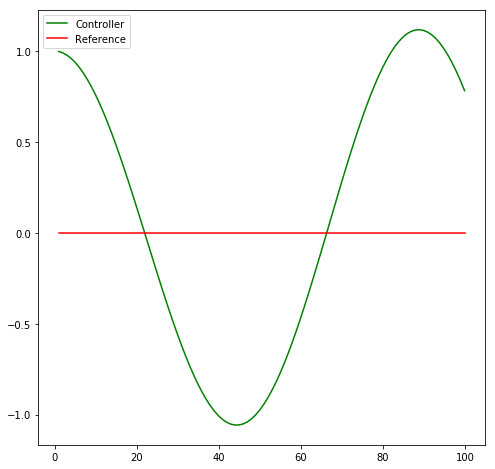

In [32]:
robot = Robot()
robot.set(0, 1, 0)
reference = 0

def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    for i in range(n):
        cte = robot.y - ref
        robot.move(-tau * cte, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    
    return x_trajectory, y_trajectory
    
x_trajectory, y_trajectory = run(robot, 0.1)
n = len(x_trajectory)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.legend(['Controller', 'Reference'])
# plt.show()

### PD Controller
Reduce oscillations 
Delta t=1

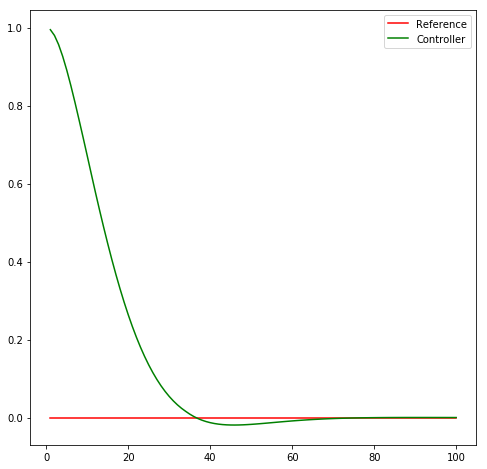

In [48]:
robot = Robot()
robot.set(0, 1, 0)

def run(robot, tau_p, tau_d, ref=0, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    cte_prev = robot.y
    for i in range(n):
        cte = robot.y - ref
        steering = -tau_p * cte - tau_d * (cte - cte_prev)
        robot.move(steering, speed)
        cte_prev = cte
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
    
x_trajectory, y_trajectory = run(robot, 0.2, 3.0)
n = len(x_trajectory)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.legend(['Reference', 'Controller'])

### PID Controller
Integral helps with systematic bias

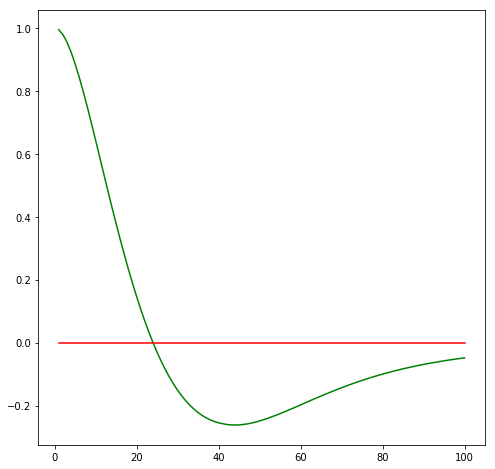

In [54]:
robot = Robot()
robot.set(0, 1, 0)


def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    cte_prev = robot.y
    cte_sum = 0
    ref = 0
    for i in range(n):
        cte = robot.y - ref
        diff = cte - cte_prev
        cte_prev = cte
        cte_sum += cte
        steering = -tau_p * cte - tau_d * (diff) - tau_i * (cte_sum)
        robot.move(steering, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)

fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')

## Twiddle algorithm to find best params

In [82]:
def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot


# params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2*n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

In [83]:
def twiddle(tol=0.02): 
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    _, _, best_err = run(robot, p)
    
    while sum(dp) > tol:
        for i in range(len(p)):
            # check error on way
            p[i] += dp[i]
            robot = make_robot()
            _, _, err = run(robot, p)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                # check error in other direction
                p[i] -= 2 * dp[i]
                robot = make_robot()
                _, _, err = run(robot, p)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else: # otherwise zoom in
                    p[i] += dp[i]
                    dp[i] *= 0.9
    return p, best_err

Final twiddle error = 3.5627222449060256e-17


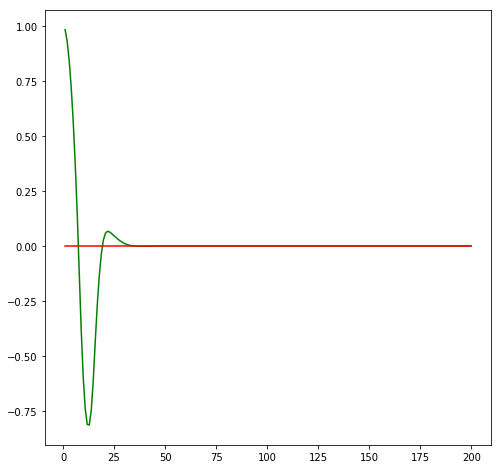

In [84]:
params, err = twiddle(0.000002)
print("Final twiddle error = {}".format(err))
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')